In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.INFO)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = False

# NOTES
NOTES = "mobilenetv2-96"

# Vars
target_label = "label"
id_label = "ImageId"
TYPE = "TLNN"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
if TEST:
    LEARNING_STEPS = 250
    LEARNING_RATE = 0.01
    BATCH_SIZE = 10
else:
    LEARNING_STEPS = 2500
    LEARNING_RATE = 0.01
    BATCH_SIZE = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
}

In [2]:
def adjust_image(data):
    # Reshape to [batch, height, width, channels].
    imgs = tf.reshape(data, [-1, 28, 28, 1])
    # Adjust image size to Inception-v3 input.
    imgs = tf.image.resize_images(imgs, (96, 96))
    # Convert to RGB image.
    imgs = tf.image.grayscale_to_rgb(imgs)
    return imgs

def display(img, w, h):
    one_image = img.reshape(w,h)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

def mobilenet_model_fn(features, labels, mode):
    # Load mobilenet-v2 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1")
    input_layer = adjust_image(features["x"])
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

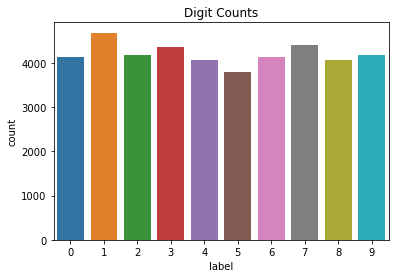

In [3]:
train_data = pd.read_csv(paths["Training"], sep=",").astype(np.int32)
if TEST:
    train_data = train_data.head(1000)
train_data = train_data.reindex(np.random.permutation(train_data.index))
ax = sns.countplot(x="label", data=train_data)
ax.set_title("Digit Counts")
train_labels = np.asarray(train_data.pop(target_label), dtype=np.int32)
train_data = train_data / 255
train_data = np.asarray(train_data, dtype=np.float32)

t_size = int(0.8 * train_data.shape[0])

validation_data = train_data[t_size:]
validation_labels = train_labels[t_size:]
train_data = train_data[:t_size]
train_labels = train_labels[:t_size]

eval_data = pd.read_csv(paths["Testing"], sep=",")
eval_labels = pd.read_csv(paths["Submission"], sep=",")["Label"]
if TEST:
    eval_data = eval_data.head(1000)
    eval_labels = eval_labels.head(1000)
eval_data = eval_data / 255
eval_data = np.asarray(eval_data, dtype=np.float32)
eval_labels = np.asarray(eval_labels, dtype=np.int32)

In [4]:
print("TRAINING")
print(train_data.shape)
print(train_labels.shape)
print("-" * 40)
print("VALIDATION")
print(validation_data.shape)
print(validation_labels.shape)
print("-" * 40)
print("EVALUATION")
print(eval_data.shape)
print(eval_labels.shape)
print(set(eval_labels))

TRAINING
(33600, 784)
(33600,)
----------------------------------------
VALIDATION
(8400, 784)
(8400,)
----------------------------------------
EVALUATION
(28000, 784)
(28000,)
{0}


In [5]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=mobilenet_model_fn, model_dir="/tmp/convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_model_dir': '/tmp/convnet_model', '_log_step_count_steps': 100, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f53aa27f2b0>, '_task_id': 0, '_train_distribute': None, '_master': '', '_is_chief': True, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_summary_steps': 100, '_evaluation_master': '', '_task_type': 'worker', '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_save_checkpoints_steps': None}


In [6]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=BATCH_SIZE,
    num_epochs=None,
    shuffle=True)

training_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    num_epochs=1,
    shuffle=False)

validation_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": validation_data},
    y=validation_labels,
    num_epochs=1,
    shuffle=False)

In [7]:
# layers = 3
# units = [nearest_2(math.ceil(t_size ** (1/i))) for i in range(2, 2+layers)]
# print(units)
# unitstr = "_".join([str(x) for x in units])

# classifier, accuracy = train_nn_classification_model(
#     learning_rate=LEARNING_RATE,
#     steps=LEARNING_STEPS,
#     hidden_units=units,
#     batch_size=BATCH_SIZE,
#     training_examples=training_examples,
#     training_targets=training_targets,
#     validation_examples=validation_examples,
#     validation_targets=validation_targets)
# print("Final accuracy on validation set: {:.2f}%".format(accuracy * 100))

In [8]:
logging_hook = tf.train.LoggingTensorHook({"loss" : "loss"}, every_n_iter=10)

In [9]:
periods = LEARNING_STEPS // 100
steps_per_period = LEARNING_STEPS // periods
t_accs = []
v_accs = []
t_lls = []
v_lls = []
print("Training model...\nMetrics:")
print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
for period in range(periods):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period,
        hooks=[logging_hook])
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
    print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
    t_lls.append(t_ll);
    v_lls.append(v_ll)
    t_accs.append(t_acc)
    v_accs.append(v_acc)
accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100

Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1'.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/proj

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwis

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-10:41:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-200
INFO:tensorflo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilen

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 fr

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a8

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-300
INFO:tensorflow:Running local

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/Ba

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilen

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-10:56:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-10:59:56
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.925565, global_step = 500, loss = 0.251321
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable 

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 601 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xfc\x98[>'
INFO:tensorflow:step = 601, loss = 0.214451
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x157nS>' (5.718 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15*\x8bv>' (5.610 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xe267>' (5.623 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15%\xdd`>' (5.620 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/dept

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-11:12:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-11:15:28
INFO:tensorflow:Saving dict for global step 800: accuracy = 0.927857, global_step = 800, loss = 0.23124
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 901 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xdb\x17\xa5>'
INFO:tensorflow:step = 901, loss = 0.322448
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15<\xe0<>' (5.838 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xac\xf6|>' (5.590 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xec\xc7S>' (5.617 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15wE\x84>' (5.609 sec)
INFO:tensorflow:loss = b'\n\x0b

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwi

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/Ba

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/Batc

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1201 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15&\xc4\x8a>'
INFO:tensorflow:step = 1201, loss = 0.271028
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xa9P\xcf=' (6.281 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\x87\xedR>' (5.599 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xd4\xa23>' (5.699 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15{\xa4F>' (5.592 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xb3\x9f\\>' (5.608 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\n\x1co>' (5.622 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xdd\x13\x01>' (5.602 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15)]E>' (5.618 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\x02\xee\x80>' (5.611 sec)
INFO:tensorflow:Saving checkpoints for 1300 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.141443.
INFO:tensorflow:Calling model_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/proj

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-11:46:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-11:47:31
INFO:tensorflow:Saving dict for global step 1400: accuracy = 0.943214, global_step = 1400, loss = 0.183168
	13	LgLs	0.18	0.18
		Acc.	94.53%	94.32%

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 fr

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15n\xcf=>' (5.595 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\xe4\x19g>' (5.602 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\t\xea\x84>' (5.607 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15k\\\xb1=' (5.632 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15R\xd8\t>' (5.701 sec)
INFO:tensorflow:Saving checkpoints for 1600 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.190186.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/mo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/Ba

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-12:02:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-1700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-12:03:06
INFO:tensorflow:Saving dict for global step 1700: accuracy = 0.942619, global_step = 1700, loss = 0.185127
	16	LgLs	0.18	0.19
		Acc.	94.

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 fr

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15;\x9f\x1b>' (5.862 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15d\xa0*>' (5.608 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\x92\x05G>' (5.639 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15@\xef\xf8=' (5.608 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\x0e*Y>' (5.604 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15w&@>' (5.627 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\x14\xc6\x00>' (5.634 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15g\x8a\x04>' (5.636 sec)
INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15\x1c\x85\xe8=' (5.627 sec)
INFO:tensorflow:Saving checkpoints for 1900 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.194037.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwi

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable 

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-12:17:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-12:18:44
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.948333, global_step = 2000, loss = 0.169008
	19	LgLs	0.16	0.17
		Acc.	95.00%	94.83%

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/biases:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/biases
INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable 

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:loss = b'\n\x0b\n\x04loss\x15w\xf9\x18>' (5.622 sec)
INFO:tensorflow:Saving checkpoints for 2200 into /tmp/convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.195186.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhu

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/var

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv_1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv_1/weights:0 from checkpoint b'/tmp

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/dept

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-01-12:33:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/convnet_model/model.ckpt-2300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-01-12:34:22
INFO:tensorflow:Saving dict for global step 2300: accuracy = 0.9475, global_step = 2300, loss = 0.163966
	22	LgLs	0.16	0.16
		Acc.	95.07%	94.75%

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable mo

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/Logits/Conv2d_1c_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Logits/Conv2d_1c_1x1/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/depthwise/BatchNorm/moving_mean


INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_10/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/projec

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/depthwise/Batc

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variable

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/e

INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_co

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_con

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/project/BatchNorm/

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobilenet

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/dept

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables'

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/expan

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/depthwise/BatchNor

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_13/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_13/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_15/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_2/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_2/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_4/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_4/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_6/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_6/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/dept

Final accuracy (on validation data): 95.2024%


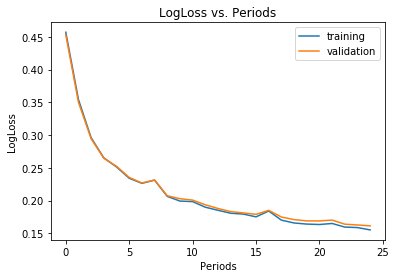

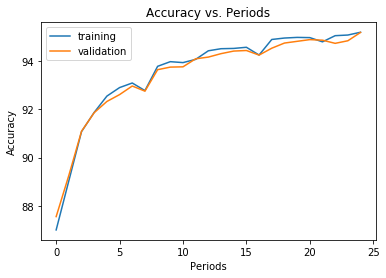

In [10]:
print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# Output a graph of loss metrics over periods.
plt.ylabel("LogLoss")
plt.xlabel("Periods")
plt.title("LogLoss vs. Periods")
plt.plot(t_lls, label="training")
plt.plot(v_lls, label="validation")
plt.legend()
plt.show()

# Output a graph of accuracy over periods.
plt.ylabel("Accuracy")
plt.xlabel("Periods")
plt.title("Accuracy vs. Periods")
plt.plot(t_accs, label="training")
plt.plot(v_accs, label="validation")
plt.legend()
plt.show()

In [11]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
stats = classifier.evaluate(input_fn=eval_input_fn)
t_accuracy = 100 * stats["accuracy"]
print("Accuracy on evaluation data (expected ~10%): {:.2f}%".format(t_accuracy))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/moving_m

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expa

In [12]:
# Make Predictions and output the results
predictions = np.array([item['classes'] for item in classifier.predict(input_fn=eval_input_fn)])
ids = np.array([i + 1 for i in range(len(predictions))])
output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/Conv/weights:0 from c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_1/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_1/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_10/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_c

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_11/project/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_11/project/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_12/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_12/depthw

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_14/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_14/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/v

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/depthwise/depthwise_weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_16/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_16/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with Mobile

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_3

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_5/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_5/pro

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/expand/weights:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/expand/weights
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_7/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_7/project/BatchN

INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/beta
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/gamma:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded_conv_9/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/MobilenetV2/expanded_conv_9/project/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/7ef3c6a879de4dbabff69b960152ff8bd79305aa/variables/variables' with MobilenetV2/expanded

In [13]:
name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
print("Filename: '{}'".format(name))
if not TEST:
    output.to_csv(name, index=False)

Filename: 'A95.2024_TypeTLNN_LR0.01_S2500_B100_mobilenetv2-96.csv'
